<a href="https://colab.research.google.com/github/yardsale8/example/blob/master/exercise_4_translate_to_python_polars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python basics

### Importing from Modules

* **Basic syntax** `import polars`
* **Standard practice** `import polars as pl`

In [ ]:
import polars as pl

### Object Oriented Design in Python

Everything is an object
* **Attributes:** Attached variables
* **Methods:** Attached functions


#### Method Example - Dot-chaining `str` methods

In [ ]:
s = "Do the difficult things while they are easy and do the great things while they are small."


**Note.** Putting `:=` inside parentheses makes an assignment expression that
1. Saves value on the LHS to the variable in the RHS
2. Returns the value.

In [ ]:
(s2 :=
 s
 .lower()
 .replace("do", "put off")
)


'put off the difficult things while they are easy and put off the great things while they are small.'

### Chaining methods is like piping

<img src="./img/r_pipe.png" width=800>

## Write and test a great distance function


### Code from Tableau Prep

Here is the code from Tableau Prep
```{Tableau}
6371*ACOS(
	SIN(RADIANS([Lat 1]))*
    SIN(RADIANS( 40.783056))
	+
    COS(RADIANS([Lat 1]))*
    COS(RADIANS( 40.783056))*
    COS(RADIANS([Long 1]) -
    	RADIANS(-73.958889)
       )
)
```

In [ ]:
def great_circle_distance(lat_col, lng_col, lat2, lng2):
    """Create a polars expression for computing the great circle distance.

    Args:
        lat_col(string): The name of the lat (float) column
        lng_col(string): The name of the long (float) column
        lat2 (float): The fixed latitude.
        lng2 (float): The fixed longitude.

    Returns: A polars column expression which can be used in `with_columns`
    """
    return (pl.col(lat_col).radians().sin()*
            pl.lit(lat2).radians().sin()
            +
            pl.col(lat_col).radians().cos()*
            pl.lit(lat2).radians().cos()*
            (pl.col(lng_col).radians() -
            pl.lit(lng2).radians()
            ).cos()
           ).arccos()*6371

### Checking that the function works

In [ ]:
(lat_long_example :=
 pl.read_csv("https://raw.githubusercontent.com/WSU-DataScience/USCOTS25_code_in_intro_data_science_workshop/refs/heads/main/example_1_museum_bike_tour/lat_long_examples.csv"))

City 1,Lat 1,Long 1,City 2,Lat 2,Long 2,Distance from Web (km)
str,f64,f64,str,f64,f64,f64
"""Winona, MN""",44.050556,-91.66833,"""Ames, IA""",42.018056,-93.62,276.48
"""Glagow, Scotland, UK""",55.861111,-4.25,"""Ames, IA""",42.018056,-93.62,6237.63


In [ ]:
(lat_long_example
 .with_columns(distance = great_circle_distance('Lat 1', 'Long 1', 42.018056,  -93.62))
 .with_columns(difference = pl.col('distance') - pl.col('Distance from Web (km)'),
               )

)

City 1,Lat 1,Long 1,City 2,Lat 2,Long 2,Distance from Web (km),distance,difference
str,f64,f64,str,f64,f64,f64,f64,f64
"""Winona, MN""",44.050556,-91.66833,"""Ames, IA""",42.018056,-93.62,276.48,276.096746,-0.383254
"""Glagow, Scotland, UK""",55.861111,-4.25,"""Ames, IA""",42.018056,-93.62,6237.63,6231.441031,-6.188969


## Exercise 4 - Translating to code

Process outline
1. Read CSV + Initial SELECT + correct data types *[DONE]*
2. Grouped aggregation to get unique station per row.
3. Compute the distance for each museum.
4. Use IF and CASE to get closest museum.
5. Use PARTITION + ORDER BY to rank then FILTER

### Step 1 - Read the csv, initial select, and fix types

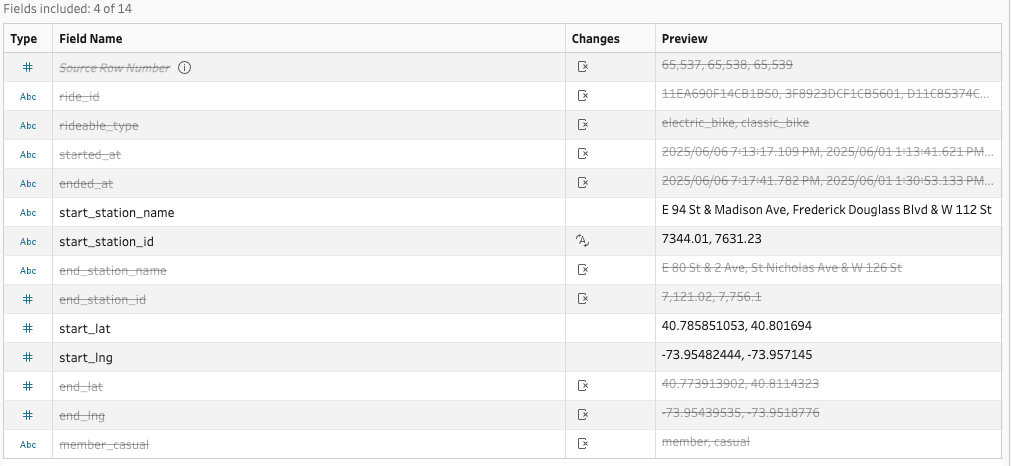


In [ ]:
city_bike_url = "https://raw.githubusercontent.com/WSU-DataScience/USCOTS25_code_in_intro_data_science_workshop/refs/heads/main/example_1_museum_bike_tour/citibike-tripdata_cent_park_6_1_to_6_7_25.csv"

In [ ]:
(city_bike :=
 pl.read_csv(city_bike_url,
             columns = ["start_station_name",
                        "start_station_id",
                        "start_lat",
                        "start_lng",
                       ],
             dtypes = {"start_station_name": pl.String(),
                       "start_station_id": pl.String(),
                       "start_lat": pl.Float64(),
                       "start_lng": pl.Float64(),
                      },
            )
).head()

/var/folders/k4/_tynxgnx6l39rvqmb6z2_mmh0000gn/T/ipykernel_84763/3989625226.py:2: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  pl.read_csv(city_bike_url,


start_station_name,start_station_id,start_lat,start_lng
str,str,f64,f64
"""E 77 St & 3 Ave""","""7092.06""",40.773142,-73.958562
"""Broadway & W 58 St""","""6948.10""",40.766953,-73.981693
"""W 44 St & 11 Ave""","""6756.05""",40.762009,-73.996975
"""W 106 St & Central Park W""","""7606.01""",40.798186,-73.960591
"""E 68 St & 3 Ave""","""6896.16""",40.767128,-73.962246


### Step 2 - Grouped aggregation

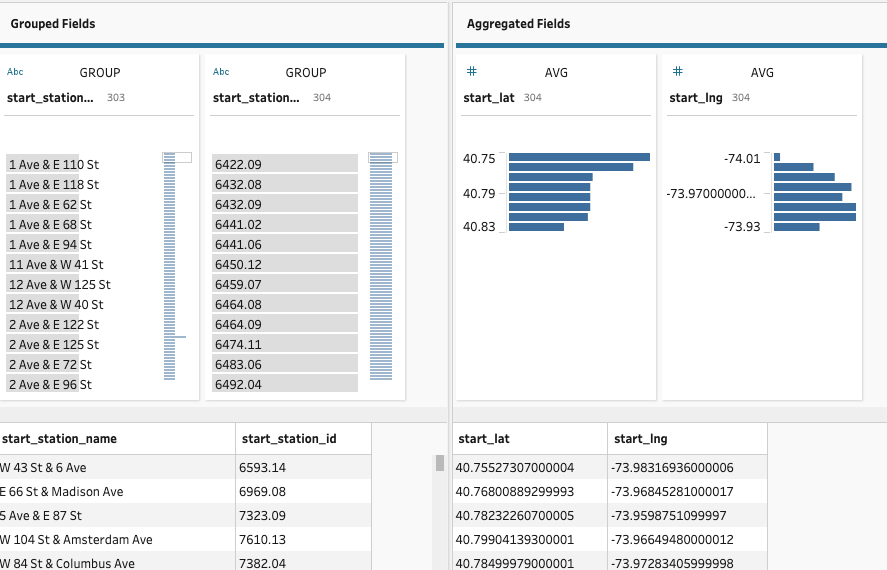

In [ ]:
(city_bike_2 :=
 city_bike
 .group_by(['start_station_name',
            'start_station_id',
           ])
 .agg(start_lat = pl.mean('start_lat'),
      start_lng = pl.mean('start_lng')
     )
)

start_station_name,start_station_id,start_lat,start_lng
str,str,f64,f64
"""W 42 St & 8 Ave""","""6602.05""",40.75757,-73.990985
"""Mt Morris Park W & W 120 St""","""7685.14""",40.804038,-73.945925
"""Madison Ave & E 120 St""","""7667.04""",40.80295,-73.942954
"""Broadway & W 53 St""","""6779.05""",40.763441,-73.982681
"""Convent Ave & W 135 St""","""7860.08""",40.818215,-73.950988
…,…,…,…
"""Central Park W & W 97 St""","""7538.18""",40.792495,-73.964171
"""E 47 St & 2 Ave""","""6498.10""",40.753231,-73.970325
"""Riverside Dr & W 145 St""","""8018.04""",40.827305,-73.951989


### Step 3 - Compute the great cirle distance for each museum

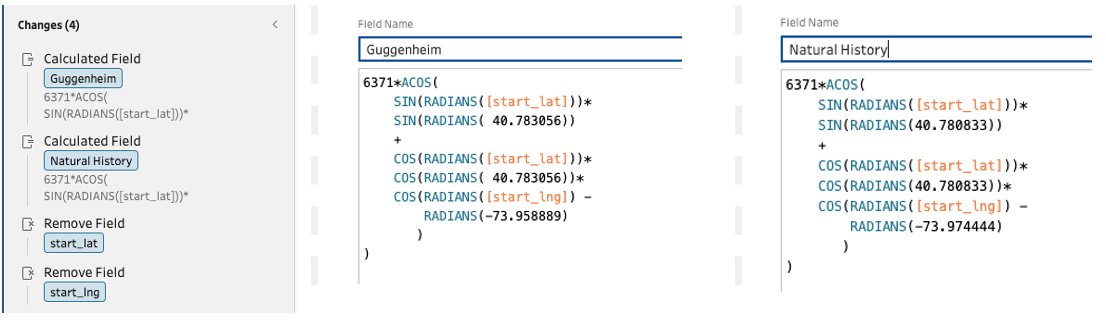


In [ ]:
gug_lat, gug_lng = (40.783056, -73.958889)
nh_lat, nh_lng = (40.780833, -73.974444)


In [ ]:
(city_bike_3 :=
 city_bike_2
 .with_columns(guggenheim = great_circle_distance('start_lat', 'start_lng', gug_lat, gug_lng),
               natural_history = great_circle_distance('start_lat', 'start_lng', nh_lat, nh_lng),
              )
 .drop(['start_lat', 'start_lng'])
).head()

start_station_name,start_station_id,guggenheim,natural_history
str,str,f64,f64
"""W 42 St & 8 Ave""","""6602.05""",3.916197,2.937957
"""Mt Morris Park W & W 120 St""","""7685.14""",2.575721,3.524462
"""Madison Ave & E 120 St""","""7667.04""",2.587071,3.616041
"""Broadway & W 53 St""","""6779.05""",2.961648,2.054585
"""Convent Ave & W 135 St""","""7860.08""",3.965666,4.601773


### Step 4 - Get the closest museum to each station

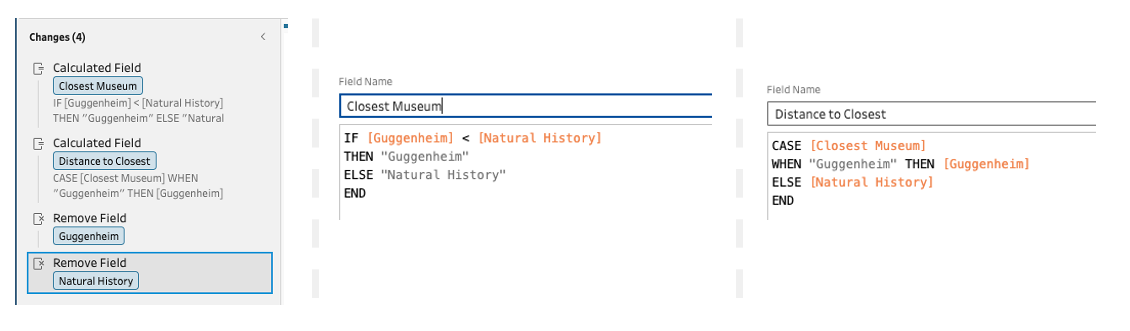

In [ ]:
(city_bike_4 :=
 city_bike_3
 .with_columns(closest_museum = pl.when(pl.col('guggenheim') < pl.col('natural_history'))
                                  .then(pl.lit('guggenheim'))
                                  .otherwise(pl.lit('natural_history'))
              )
 .with_columns(distance_to_closest = pl.when(pl.col('closest_museum') == 'guggenheim')
                                       .then(pl.col('guggenheim'))
                                       .otherwise(pl.col('natural_history'))
               )
 .drop(['guggenheim', 'natural_history'])

 )

start_station_name,start_station_id,closest_museum,distance_to_closest
str,str,str,f64
"""W 42 St & 8 Ave""","""6602.05""","""natural_history""",2.937957
"""Mt Morris Park W & W 120 St""","""7685.14""","""guggenheim""",2.575721
"""Madison Ave & E 120 St""","""7667.04""","""guggenheim""",2.587071
"""Broadway & W 53 St""","""6779.05""","""natural_history""",2.054585
"""Convent Ave & W 135 St""","""7860.08""","""guggenheim""",3.965666
…,…,…,…
"""Central Park W & W 97 St""","""7538.18""","""guggenheim""",1.139896
"""E 47 St & 2 Ave""","""6498.10""","""natural_history""",3.088743
"""Riverside Dr & W 145 St""","""8018.04""","""guggenheim""",4.95442


### Step 5 - Group rank and filter

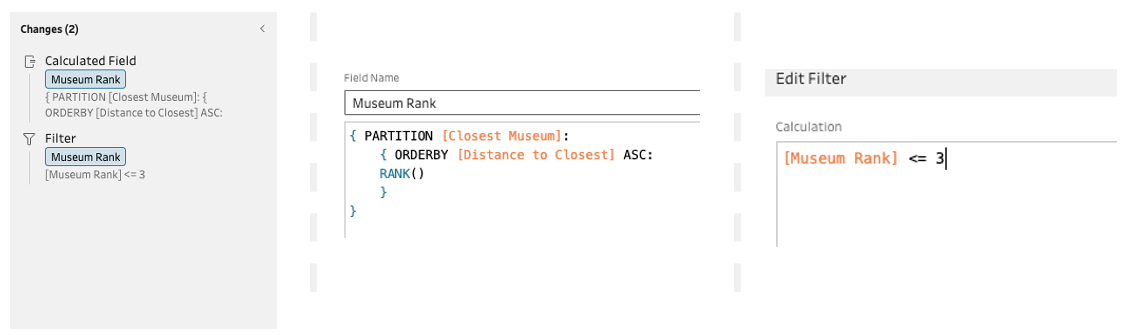

In [ ]:
(city_bike_5 :=
 city_bike_4
 .with_columns(rank = pl.col('distance_to_closest')
                        .rank('dense', descending = False)
                        .over('closest_museum')
              )
 .filter(pl.col('rank') <= 3)
)

start_station_name,start_station_id,closest_museum,distance_to_closest,rank
str,str,str,f64,u32
"""E 91 St & Park Ave""","""7344.05""","""guggenheim""",0.303969,2
"""E 88 St & Park Ave""","""7293.10""","""guggenheim""",0.307125,3
"""Central Park W & W 76 St""","""7253.04""","""natural_history""",0.215531,1
"""W 76 St & Columbus Ave""","""7281.09""","""natural_history""",0.249885,2
"""W 82 St & Central Park W""","""7304.08""","""natural_history""",0.3353,3
"""5 Ave & E 87 St""","""7323.09""","""guggenheim""",0.116378,1


## Putting all together in one dot-chain

In [ ]:
(city_bike :=
 pl.read_csv(city_bike_url,
             columns = ["start_station_name",
                        "start_station_id",
                        "start_lat",
                        "start_lng",
                       ],
             dtypes = {"start_station_name": pl.String(),
                       "start_station_id": pl.String(),
                       "start_lat": pl.Float64(),
                       "start_lng": pl.Float64(),
                      },
            )
).head()

/var/folders/k4/_tynxgnx6l39rvqmb6z2_mmh0000gn/T/ipykernel_84763/3989625226.py:2: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  pl.read_csv(city_bike_url,


start_station_name,start_station_id,start_lat,start_lng
str,str,f64,f64
"""E 77 St & 3 Ave""","""7092.06""",40.773142,-73.958562
"""Broadway & W 58 St""","""6948.10""",40.766953,-73.981693
"""W 44 St & 11 Ave""","""6756.05""",40.762009,-73.996975
"""W 106 St & Central Park W""","""7606.01""",40.798186,-73.960591
"""E 68 St & 3 Ave""","""6896.16""",40.767128,-73.962246


In [ ]:
(closest_museum :=
 city_bike
 .group_by(['start_station_name',
            'start_station_id'])
 .agg(start_lat = pl.mean('start_lat'),
      start_lng = pl.mean('start_lng')
     )
 .with_columns(guggenheim = great_circle_distance('start_lat', 'start_lng', 40.783056, -73.958889),
               natural_history = great_circle_distance('start_lat', 'start_lng', 40.780833, -73.974444),
              )
 .drop(['start_lat', 'start_lng'])
 .with_columns(closest_museum = pl.when(pl.col('guggenheim') < pl.col('natural_history'))
                                  .then(pl.lit('guggenheim'))
                                  .otherwise(pl.lit('natural_history'))
              )
 .with_columns(distance_to_closest = pl.when(pl.col('closest_museum') == 'guggenheim')
                                       .then(pl.col('guggenheim'))
                                       .otherwise(pl.col('natural_history'))
               )
 .drop(['guggenheim', 'natural_history'])
 .with_columns(rank = pl.col('distance_to_closest')
                        .rank('dense', descending = False)
                        .over('closest_museum')
              )
 .filter(pl.col('rank') <= 3)
)


start_station_name,start_station_id,closest_museum,distance_to_closest,rank
str,str,str,f64,u32
"""W 76 St & Columbus Ave""","""7281.09""","""natural_history""",0.249885,2
"""E 91 St & Park Ave""","""7344.05""","""guggenheim""",0.303969,2
"""5 Ave & E 87 St""","""7323.09""","""guggenheim""",0.116378,1
"""E 88 St & Park Ave""","""7293.10""","""guggenheim""",0.307125,3
"""Central Park W & W 76 St""","""7253.04""","""natural_history""",0.215531,1
"""W 82 St & Central Park W""","""7304.08""","""natural_history""",0.3353,3


## <font color="red"> Exerise 5 - Three Museum Trip </font>
Now adapt the code to find the closest Sity Bike station to all three museums,


In [ ]:
gug_lat, gug_lng = (40.783056, -73.958889)
nh_lat, nh_lng = (40.780833, -73.974444)
moma_lat, moma_lng = (40.761667, -73.9775)


In [ ]:
# Your code here